# Associate clinical data with MRI data
This notebook is used to associate the available MRI scans with corresponding visit.
We must be aware of the fact that there is no one-to-one relationship between visits and MR sessions, for this reason we will analyze three approaches
1. Associate Clinical data to the 'nearest' MR session
2. Associate Clinical data the 'forward' MR session
3. Associate Clinical data the 'backward' MR session

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns

columns_ordered = ['ADRC_ADRCCLINICALDATA_ID', 'Subject','MR_ID', 'ageAtEntry', 'Age','DaysAfterEntry_clinic', 'DaysAfterEntry_mr', 'DaysDistance',
                   'Scanner', 'T1w', 'T2w', 'Freesurfer_ID',  'mmse',
                   'cdr',  'dx1', 'dx2', 'dx3', 'dx4', 'dx5','commun',
                   'homehobb', 'judgment', 'memory', 'orient', 'perscare', 'sumbox','apoe', 'height','weight' ]

clinical_data = pd.read_csv("../data/raw/clinical-data.csv")
clinical_data["DaysAfterEntry_clinic"] = clinical_data["ADRC_ADRCCLINICALDATA_ID"].apply(lambda x: int(x.split("_")[-1][1:]))
print(f"Reads {len(clinical_data)} clinical data belonging to {len(set(clinical_data.Subject))} subjects")
mri_sessions = pd.read_csv("../data/raw/mri-scans.csv")
mri_sessions.rename(columns={'DaysAfterEntry':'DaysAfterEntry_mr'}, inplace=True)
print(f"Reads {len(mri_sessions)} MR sessions data belonging to {len(set(mri_sessions.Subject))} subjects")

sub_no_clinical = set(mri_sessions.Subject).difference(clinical_data.Subject)
print(f"Found {len(sub_no_clinical)} subjects with MR session but no clinical data")
print(f"Remove those {len(sub_no_clinical)} subjects entries from the mri sessions")
mri_sessions = mri_sessions[~mri_sessions.Subject.isin(sub_no_clinical)].reset_index(drop=True).copy()
print(f"Now we have {len(mri_sessions)} MR sessions")

Reads 6224 clinical data belonging to 1098 subjects
Reads 2842 MR sessions data belonging to 1376 subjects
Found 278 subjects with MR session but no clinical data
Remove those 278 subjects entries from the mri sessions
Now we have 2511 MR sessions


### Nearest association

In [14]:
nearest = pd.merge_asof(mri_sessions.sort_values("DaysAfterEntry_mr"),clinical_data.sort_values("DaysAfterEntry_clinic"),
                        right_on='DaysAfterEntry_clinic', left_on='DaysAfterEntry_mr', by='Subject', direction='nearest')
nearest["DaysDistance"] = np.abs(nearest.DaysAfterEntry_clinic - nearest.DaysAfterEntry_mr)
nearest = pd.concat([nearest,clinical_data]).sort_values("MR_ID").drop_duplicates(subset="ADRC_ADRCCLINICALDATA_ID").sort_values("ADRC_ADRCCLINICALDATA_ID").reset_index(drop=True)
nearest = nearest[columns_ordered]
assert len(nearest) == len(clinical_data)
print(f"Mean days difference: {nearest.DaysDistance.mean()}")
print(f"Standard deviation {nearest.DaysDistance.std()}")
nearest.head()

Mean days difference: 138.869154676259
Standard deviation 167.41098698206176


,ADRC_ADRCCLINICALDATA_ID,Subject,MR_ID,ageAtEntry,Age,DaysAfterEntry_clinic,DaysAfterEntry_mr,DaysDistance,Scanner,T1w,...,commun,homehobb,judgment,memory,orient,perscare,sumbox,apoe,height,weight
0,OAS30001_ClinicalData_d0000,OAS30001,OAS30001_MR_d0129,65.149895,65.0,0,129.0,129.0,3.0T,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,NaN,NaN
1,OAS30001_ClinicalData_d0339,OAS30001,NaN,65.149895,NaN,339,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,64.0,155.0
2,OAS30001_ClinicalData_d0722,OAS30001,OAS30001_MR_d0757,65.149895,67.0,722,757.0,35.0,3.0T,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,64.0,162.0
3,OAS30001_ClinicalData_d1106,OAS30001,NaN,65.149895,NaN,1106,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,64.0,167.0
4,OAS30001_ClinicalData_d1456,OAS30001,NaN,65.149895,NaN,1456,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,63.0,173.0


### Backward association

In [15]:
backward = pd.merge_asof(mri_sessions.sort_values("DaysAfterEntry_mr"),clinical_data.sort_values("DaysAfterEntry_clinic"),
                        right_on='DaysAfterEntry_clinic', left_on='DaysAfterEntry_mr', by='Subject', direction='backward')
backward["DaysDistance"] = np.abs(backward.DaysAfterEntry_clinic - backward.DaysAfterEntry_mr)
backward = pd.concat([backward,clinical_data]).sort_values("MR_ID").drop_duplicates(subset="ADRC_ADRCCLINICALDATA_ID").sort_values("ADRC_ADRCCLINICALDATA_ID").reset_index(drop=True)
backward = backward[columns_ordered]
assert len(backward) == len(clinical_data)
print(f"Mean days difference: {backward.DaysDistance.mean()}")
print(f"Standard deviation {backward.DaysDistance.std()}")

backward.head()

Mean days difference: 171.752855185016
Standard deviation 230.3567709184552


,ADRC_ADRCCLINICALDATA_ID,Subject,MR_ID,ageAtEntry,Age,DaysAfterEntry_clinic,DaysAfterEntry_mr,DaysDistance,Scanner,T1w,...,commun,homehobb,judgment,memory,orient,perscare,sumbox,apoe,height,weight
0,OAS30001_ClinicalData_d0000,OAS30001,OAS30001_MR_d0129,65.149895,65.0,0,129.0,129.0,3.0T,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,NaN,NaN
1,OAS30001_ClinicalData_d0339,OAS30001,NaN,65.149895,NaN,339,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,64.0,155.0
2,OAS30001_ClinicalData_d0722,OAS30001,OAS30001_MR_d0757,65.149895,67.0,722,757.0,35.0,3.0T,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,64.0,162.0
3,OAS30001_ClinicalData_d1106,OAS30001,NaN,65.149895,NaN,1106,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,64.0,167.0
4,OAS30001_ClinicalData_d1456,OAS30001,NaN,65.149895,NaN,1456,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,63.0,173.0


### Forward Association

In [16]:
forward = pd.merge_asof(mri_sessions.sort_values("DaysAfterEntry_mr"),clinical_data.sort_values("DaysAfterEntry_clinic"),
                         right_on='DaysAfterEntry_clinic', left_on='DaysAfterEntry_mr', by='Subject', direction='forward')
forward["DaysDistance"] = np.abs(forward.DaysAfterEntry_clinic - forward.DaysAfterEntry_mr)
forward = pd.concat([forward,clinical_data]).sort_values("MR_ID").drop_duplicates(subset="ADRC_ADRCCLINICALDATA_ID").sort_values("ADRC_ADRCCLINICALDATA_ID")
forward = forward[forward.ADRC_ADRCCLINICALDATA_ID.notna()].reset_index(drop=True)
forward = forward[columns_ordered]
assert len(forward) == len(clinical_data)
print(f"Mean days difference: {forward.DaysDistance.mean()}")
print(f"Standard deviation {forward.DaysDistance.std()}")

forward.head()

Mean days difference: 401.5512167515563
Standard deviation 319.47118245374514


,ADRC_ADRCCLINICALDATA_ID,Subject,MR_ID,ageAtEntry,Age,DaysAfterEntry_clinic,DaysAfterEntry_mr,DaysDistance,Scanner,T1w,...,commun,homehobb,judgment,memory,orient,perscare,sumbox,apoe,height,weight
0,OAS30001_ClinicalData_d0000,OAS30001,NaN,65.149895,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,NaN,NaN
1,OAS30001_ClinicalData_d0339,OAS30001,OAS30001_MR_d0129,65.149895,65.0,339.0,129.0,210.0,3.0T,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,64.0,155.0
2,OAS30001_ClinicalData_d0722,OAS30001,NaN,65.149895,NaN,722.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,64.0,162.0
3,OAS30001_ClinicalData_d1106,OAS30001,OAS30001_MR_d0757,65.149895,67.0,1106.0,757.0,349.0,3.0T,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,64.0,167.0
4,OAS30001_ClinicalData_d1456,OAS30001,NaN,65.149895,NaN,1456.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,63.0,173.0


## Comparison

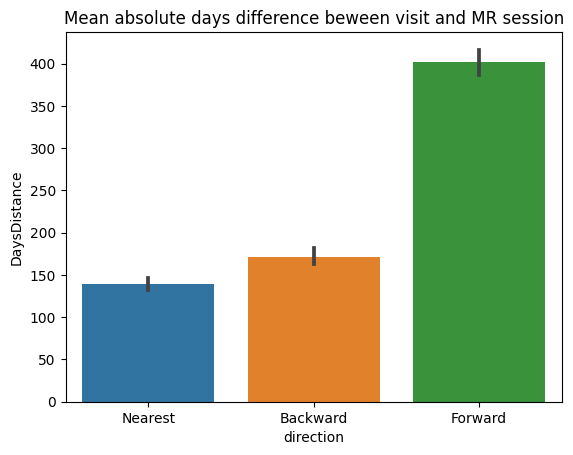

In [17]:
data = pd.concat([
    nearest[nearest.MR_ID.notna()], backward[backward.MR_ID.notna()], forward[forward.MR_ID.notna()]
], keys=["Nearest", "Backward", "Forward"]).reset_index().rename(columns={"level_0":'direction'})
img = sns.barplot(data=data, x="direction", y="DaysDistance")
img.set_title("Mean absolute days difference beween visit and MR session")

img.figure.savefig("../reports/figures/mean_diff_days_comparison.png", bbox_inches='tight', dpi=300, transparent=True)

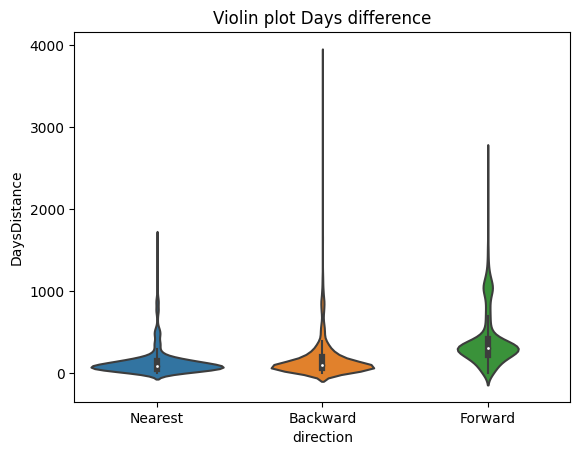

In [18]:
img = sns.violinplot(data=data, x="direction", y="DaysDistance")
img.set_title("Violin plot Days difference")
img.figure.savefig("../reports/figures/violin_diff_days.png", bbox_inches='tight', dpi=300, transparent=True)

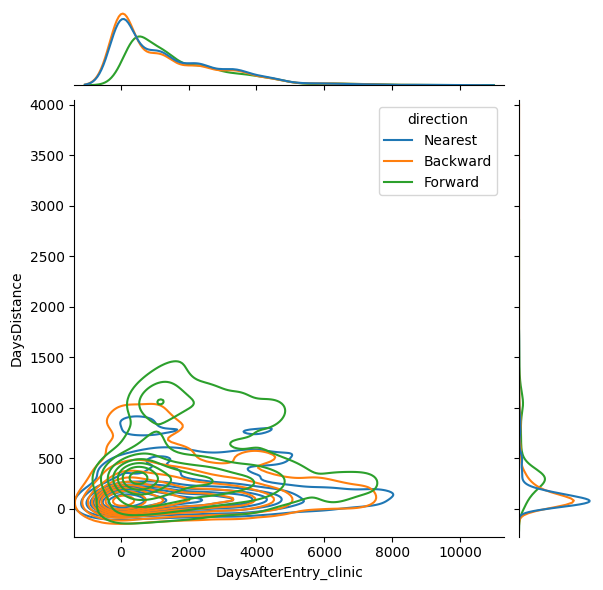

In [19]:
img = sns.jointplot(data=data, x='DaysAfterEntry_clinic',y="DaysDistance", kind='kde', hue="direction")

img.figure.savefig("../reports/figures/joint_days.png", bbox_inches='tight', dpi=300, transparent=True)

## Conclusions
We can observe that the 'nearest' association exhibit a lower absolute difference in days using the nearest criterion so we will use this kind of join criterion.
The joined file will be saved and used when needed.

In [20]:
clinical_mri = nearest.sort_values("ADRC_ADRCCLINICALDATA_ID").reset_index(drop=True)
clinical_mri.to_csv("../data/interim/clinical-mri.csv", index=False)
clinical_mri.dtypes

ADRC_ADRCCLINICALDATA_ID     object
Subject                      object
MR_ID                        object
ageAtEntry                  float64
Age                         float64
DaysAfterEntry_clinic         int64
DaysAfterEntry_mr           float64
DaysDistance                float64
Scanner                      object
T1w                         float64
T2w                         float64
Freesurfer_ID                object
mmse                        float64
cdr                         float64
dx1                          object
dx2                          object
dx3                          object
dx4                          object
dx5                          object
commun                      float64
homehobb                    float64
judgment                    float64
memory                      float64
orient                      float64
perscare                    float64
sumbox                      float64
apoe                        float64
height                      

### Subject demographyc analysis
Demographyc analysis on the associated mri scans and clinical data, from the complete list that contains all the clinical data we will not consider the entries that don't have an associated MR session

In [21]:
subjects = pd.read_csv("../data/raw/subjects.csv")
demos = pd.merge(clinical_mri[clinical_mri.MR_ID.notna()], subjects, on="Subject", how='left')
demos.head()

,ADRC_ADRCCLINICALDATA_ID,Subject,MR_ID,ageAtEntry,Age,DaysAfterEntry_clinic,DaysAfterEntry_mr,DaysDistance,Scanner,T1w,...,apoe,height,weight,Gender,Hand,Education,MR Count,Race,Ethnicity,M/F
0,OAS30001_ClinicalData_d0000,OAS30001,OAS30001_MR_d0129,65.149895,65.0,0,129.0,129.0,3.0T,2.0,...,23.0,NaN,NaN,female,right,12.0,4.0,Caucasian,Non-Hispanic,F
1,OAS30001_ClinicalData_d0722,OAS30001,OAS30001_MR_d0757,65.149895,67.0,722,757.0,35.0,3.0T,2.0,...,23.0,64.0,162.0,female,right,12.0,4.0,Caucasian,Non-Hispanic,F
2,OAS30001_ClinicalData_d2181,OAS30001,OAS30001_MR_d2430,65.149895,71.0,2181,2430.0,249.0,3.0T,1.0,...,23.0,63.0,180.0,female,right,12.0,4.0,Caucasian,Non-Hispanic,F
3,OAS30001_ClinicalData_d3025,OAS30001,OAS30001_MR_d3132,65.149895,73.0,3025,3132.0,107.0,3.0T,1.0,...,23.0,64.0,180.0,female,right,12.0,4.0,Caucasian,Non-Hispanic,F
4,OAS30001_ClinicalData_d3675,OAS30001,OAS30001_MR_d3746,65.149895,NaN,3675,3746.0,71.0,NaN,1.0,...,23.0,64.0,192.0,female,right,12.0,4.0,Caucasian,Non-Hispanic,F


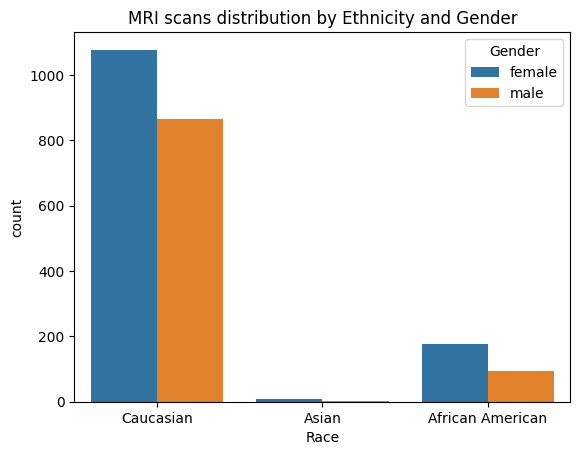

In [22]:
g = sns.countplot(data=demos, x="Race", hue="Gender")
g.set_title("MRI scans distribution by Ethnicity and Gender")
g.figure.savefig("../reports/figures/mri_distib_gender_race.png", bbox_inches='tight', dpi=300, transparent=True)

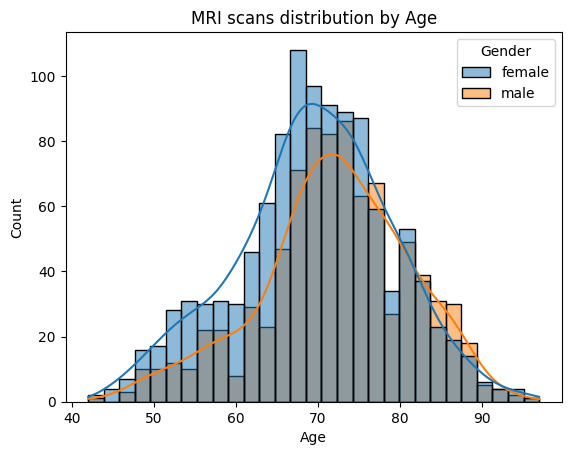

In [23]:
g = sns.histplot(data=demos, x="Age",hue="Gender", stat='count', multiple='layer', kde=True)
g.set_title("MRI scans distribution by Age")
g.figure.savefig("../reports/figures/mri_distib_gender_age.png", bbox_inches='tight', dpi=300, transparent=True)

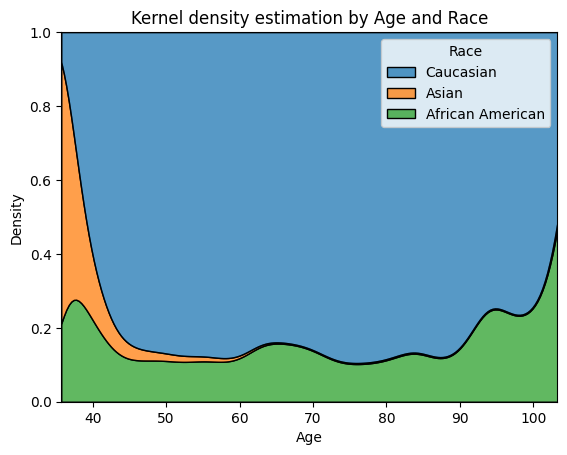

In [24]:
g = sns.kdeplot(data=demos, x="Age",hue="Race", multiple='fill')
g.set_title("Kernel density estimation by Age and Race")
g.figure.savefig("../reports/figures/mri_kde_race_age.png", bbox_inches='tight', dpi=300, transparent=True)


The dataset population is almost equally distributed across genders (55.6% F 44.4% M),
while there are consistent differences over the Ethnicity in which caucasian people are over-represented;
Therefore dataset may not be representative of the actual worldwide distribution of the AD disease.
